In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [100]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')

In [101]:
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode"])
df.head()

,Report_TransactionEffectiveDate,TransactionGroup,TransactionAmount
0,2013-12-30,D,-972.619715
1,2013-12-30,D,-75.956876
2,2013-12-30,C,127.430470
3,2013-12-30,D,-38.300469
4,2013-12-30,D,-117.467137


In [102]:
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df.head()

,TransactionGroup,TransactionAmount
Report_TransactionEffectiveDate,,
2013-12-30,D,-972.619715
2013-12-30,D,-75.956876
2013-12-30,C,127.430470
2013-12-30,D,-38.300469
2013-12-30,D,-117.467137


In [103]:
## Create Debit and Credit df
credit_df = df[df["TransactionGroup"] == "C"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')
debit_df = df[df["TransactionGroup"] == "D"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')

## Fill missing values
credit_df = credit_df.fillna(method="ffill").fillna(method="bfill")
debit_df = debit_df.fillna(method="ffill").fillna(method="bfill")

In [104]:
# Find best sarima params
def find_best_sarima_params(data, seasonal=True, m=7):
    model = auto_arima(data, seasonal=seasonal, m=m, stepwise=True, suppress_warnings=True, trace=False)
    return model.order, model.seasonal_order

credit_order, credit_seasonal= find_best_sarima_params(credit_df)
debit_order, debit_seasonal= find_best_sarima_params(debit_df)
print("Credit Order: ", credit_order)
print("Credit Seasonal: ", credit_seasonal)
print("Debit Order: ", debit_order)
print("Debit Seasonal: ", debit_seasonal)

Credit Order:  (5, 1, 5)
Credit Seasonal:  (2, 0, 2, 7)
Debit Order:  (5, 1, 0)
Debit Seasonal:  (2, 0, 0, 7)


In [105]:
def fit_arima_model(data, order, seasonal):
    model = SARIMAX(data, order=order, seasonal=seasonal, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

credit_model_test = fit_arima_model(credit_df, credit_order, credit_seasonal)
debit_model_test = fit_arima_model(debit_df, debit_order, debit_seasonal)

In [106]:
def evaluate_model(model, actual_data, label):
    predicted = model.fittedvalues
    residuals = actual_data - predicted
    mae = mean_absolute_error(actual_data, predicted)
    rmse = np.sqrt(mean_squared_error(actual_data, predicted))
    print(f"{label} Model Evaluation: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    plt.figure(figsize=(12, 5))
    plt.plot(residuals, label=f'{label} Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot for {label} Transactions')
    plt.legend()
    plt.show()
    return mae, rmse
    

Credit Model Evaluation: MAE=12557.93, RMSE=17654.33


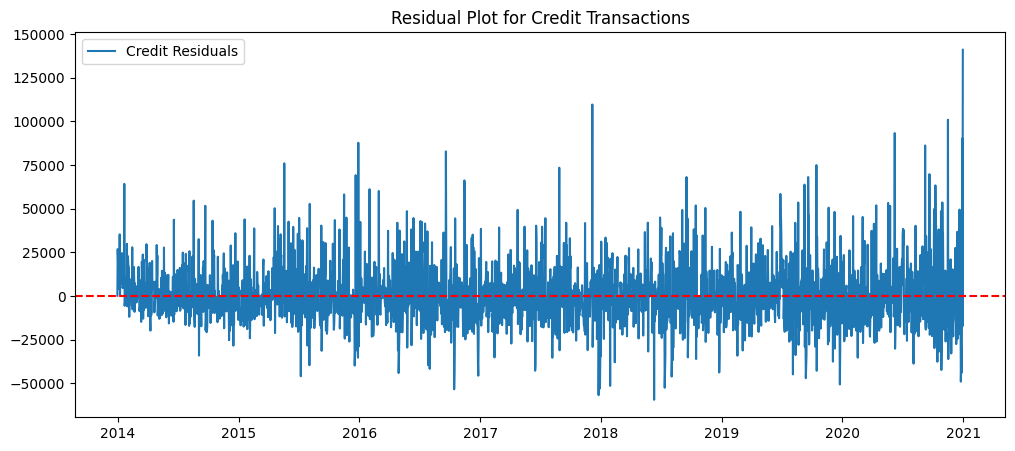

Debit Model Evaluation: MAE=12104.23, RMSE=17435.17


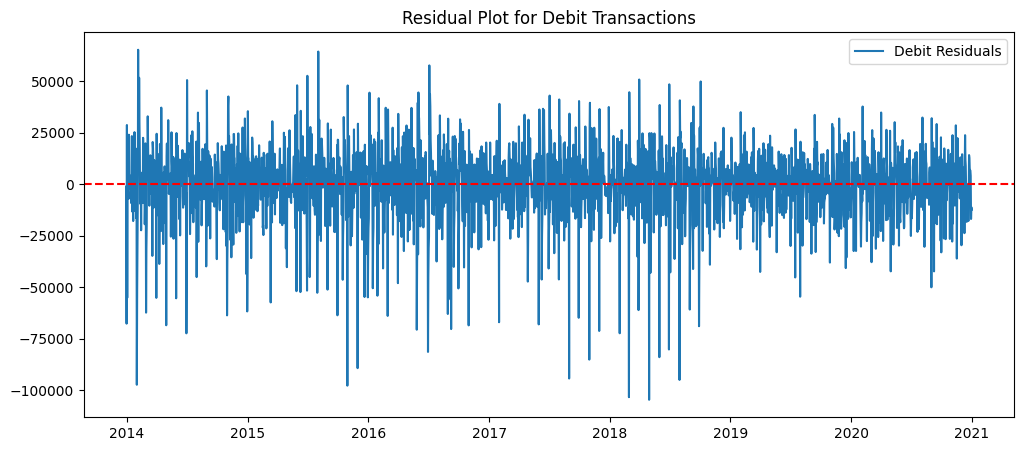

In [107]:
credit_mae, credit_rmse = evaluate_model(credit_model_test, credit_df, "Credit")
debit_mae, debit_rmse = evaluate_model(debit_model_test, debit_df, "Debit")


In [108]:
## Create model for forecasting
credit_model = fit_arima_model(credit_df, credit_order, credit_seasonal)
debit_model = fit_arima_model(debit_df, debit_order, debit_seasonal)

## Forecast 
forecast_steps = 90
credit_forecast = credit_model.forecast(steps=forecast_steps)
debit_forecast = debit_model.forecast(steps=forecast_steps)

In [109]:
forecast_index = pd.date_range(start=credit_df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecasts_df = pd.DataFrame({
    'credit_forecast': credit_forecast,
    'debit_forecast': debit_forecast,
    'total_forecast': credit_forecast + debit_forecast  # Total transaction forecast
}, index=forecast_index)


In [110]:
# Confidence Intervals
credit_ci = credit_model.get_forecast(steps=forecast_steps).conf_int()
debit_ci = debit_model.get_forecast(steps=forecast_steps).conf_int()
forecasts_df['credit_lower_ci'] = credit_ci.iloc[:, 0]
forecasts_df['credit_upper_ci'] = credit_ci.iloc[:, 1]
forecasts_df['debit_lower_ci'] = debit_ci.iloc[:, 0]
forecasts_df['debit_upper_ci'] = debit_ci.iloc[:, 1]

In [111]:
## Evaluate model
total_actual = credit_df + debit_df
total_actual

Report_TransactionEffectiveDate
2013-12-30     -1076.913729
2013-12-31    -41733.273687
2014-01-01     23416.332059
2014-01-02    -45506.653405
2014-01-03    -18386.381900
                  ...      
2020-12-27    -14363.858907
2020-12-28    -14363.858907
2020-12-29     82156.304473
2020-12-30     22316.790026
2020-12-31    152923.026916
Freq: D, Name: TransactionAmount, Length: 2559, dtype: float64

In [112]:
total_predicted = credit_model.fittedvalues + debit_model.fittedvalues
total_predicted

Report_TransactionEffectiveDate
2013-12-30        0.000000
2013-12-31     -821.554616
2014-01-01   -24449.473411
2014-01-02    -3984.608612
2014-01-03   -28414.388365
                  ...     
2020-12-27     8501.265068
2020-12-28    25522.887595
2020-12-29     8806.064096
2020-12-30    50802.918799
2020-12-31    24291.308008
Freq: D, Length: 2559, dtype: float64

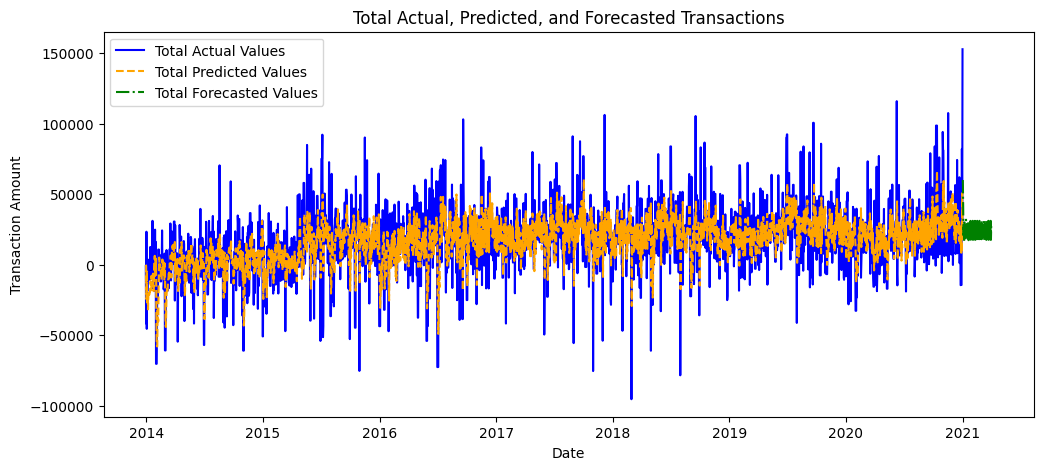

In [113]:
# Plot total actual, predicted, and forecasted values as a line graph
plt.figure(figsize=(12, 5))
plt.plot(total_actual.index, total_actual, label='Total Actual Values', color='blue')
plt.plot(total_predicted.index, total_predicted, label='Total Predicted Values', color='orange', linestyle='--')
plt.plot(forecasts_df.index, forecasts_df['total_forecast'], label='Total Forecasted Values', color='green', linestyle='-.')
plt.title('Total Actual, Predicted, and Forecasted Transactions')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

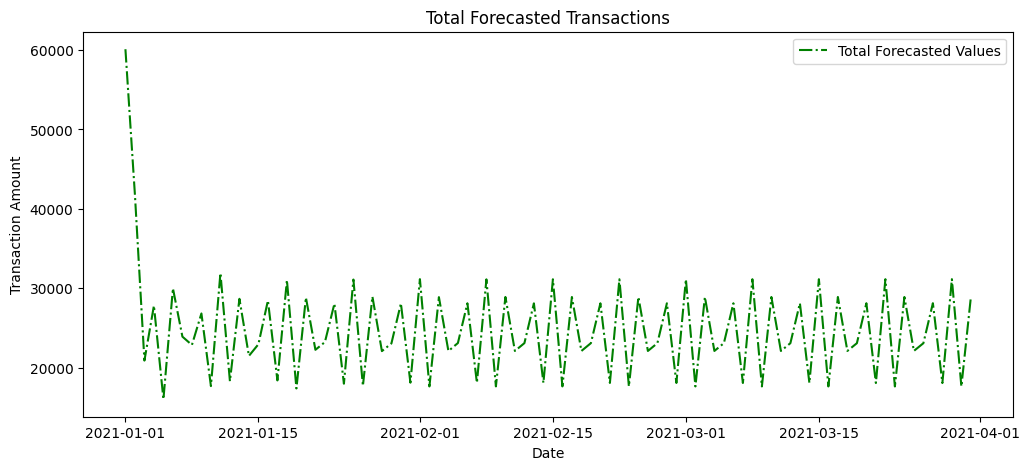

In [114]:
# Plot only the total forecasted values
plt.figure(figsize=(12, 5))
plt.plot(forecasts_df.index, forecasts_df['total_forecast'], label='Total Forecasted Values', color='green', linestyle='-.')
plt.title('Total Forecasted Transactions')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

In [115]:
forecasts_df

,credit_forecast,debit_forecast,total_forecast,credit_lower_ci,credit_upper_ci,debit_lower_ci,debit_upper_ci
2021-01-01,91971.084944,-31880.776480,60090.308464,55770.773434,128171.396454,-65905.849284,2144.296325
2021-01-02,72199.924639,-30431.844226,41768.080414,34548.370230,109851.479049,-67922.761988,7059.073536
2021-01-03,51004.008049,-30094.406671,20909.601378,12945.777789,89062.238309,-69819.264121,9630.450779
2021-01-04,59979.404966,-32154.880274,27824.524693,21859.364946,98099.444987,-73346.220692,9036.460145
2021-01-05,48822.637558,-32777.274413,16045.363145,10699.394309,86945.880807,-75502.148384,9947.599557
...,...,...,...,...,...,...,...
2021-03-27,60457.027882,-32324.975940,28132.051943,19765.790242,101148.265523,-159652.892024,95002.940145
2021-03-28,50406.592376,-32324.975940,18081.616436,9676.144806,91137.039946,-160347.187030,95697.235151
2021-03-29,63478.564019,-32324.975940,31153.588079,22723.315870,104233.812168,-161037.736963,96387.785084
2021-03-30,49974.334166,-32324.975940,17649.358226,9187.932943,90760.735389,-161724.601782,97074.649903


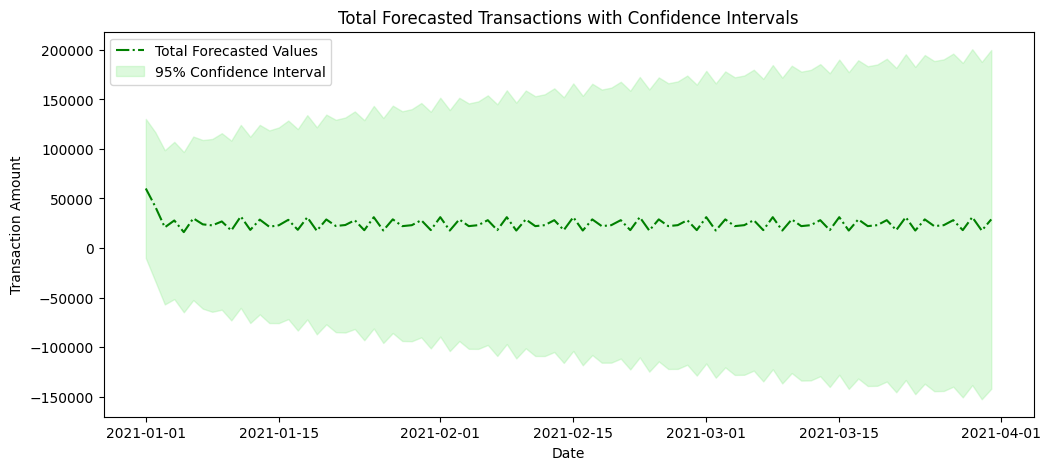

In [116]:
total_lower_ci = forecasts_df['credit_lower_ci'] + forecasts_df['debit_lower_ci']
total_upper_ci = forecasts_df['credit_upper_ci'] + forecasts_df['debit_upper_ci']

# Plot total forecasted values with confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(forecasts_df.index, forecasts_df['total_forecast'], label='Total Forecasted Values', color='green', linestyle='-.')
plt.fill_between(forecasts_df.index, total_lower_ci, total_upper_ci, color='lightgreen', alpha=0.3, label='95% Confidence Interval')
plt.title('Total Forecasted Transactions with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()